# Loading Modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from POLO.PYramid2 import cropped_pyramid, local_filter, get_K, log_gabor_transform
from POLO.PYramid2 import inverse_pyramid, get_K_inv, inverse_gabor
from utils import view_data
from typing import List, Tuple

Default lg shape= 32 32


In [2]:
#args.offset_std = 30
#args.contrast = 0.7

width = {'in': 32, 'out': 64}

n_levels = {'in': 3, 'out': 3} 

base_levels = 2

n_color = {'in': 3, 'out': 3}

color = True

color_mode= 'rgb' #'lab' # 'hsv' #True

r_min = {'in': width['in'] / 4, 'out': width['out'] / 4}

r_max = {'in': width['in'] / 2, 'out': width['out'] / 2}

n_sublevel = n_eccentricity = {'in': 2, 'out': 4}

n_azimuth = {'in': 16, 'out': 32}

n_theta = {'in': 8, 'out': 8}

n_phase = {'in': 1, 'out': 1}

do_mask = False

gauss = False






In [3]:
lg={}
for k in ['in', 'out']:
    pe = {'N_X': width[k], 'N_Y': width[k], 'do_mask': do_mask, 'base_levels':
              base_levels, 'n_theta': 0, 'B_sf': np.inf, 'B_theta': np.inf ,
          'use_cache': True, 'figpath': 'results', 'edgefigpath':
              'results/edges', 'matpath': 'cache_dir', 'edgematpath':
              'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
              14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

    lg[k] = LogGabor(pe)

In [4]:
K = {}
for k in ['in', 'out']:
    K[k] = get_K(width=width[k],
          n_sublevel = n_sublevel[k], 
          n_azimuth = n_azimuth[k], 
          n_theta = n_theta[k],
          n_phase = n_phase[k], 
          r_min = r_min[k], 
          r_max = r_max[k], 
          log_density_ratio = 2, 
          verbose=True,
          lg=lg[k])

i_sublevel, sf_0, radius 0 0.36067376022224085 8.0
i_sublevel, sf_0, radius 1 0.25503486164919736 11.31370849898476
K shape= torch.Size([32, 32, 2, 16, 8, 1])
K min max= tensor(-0.3125) tensor(1.)
i_sublevel, sf_0, radius 0 0.18033688011112042 16.0
i_sublevel, sf_0, radius 1 0.15164463602348005 19.027313840043536
i_sublevel, sf_0, radius 2 0.12751743082459868 22.62741699796952
i_sublevel, sf_0, radius 3 0.10722895046276856 26.908685288118864
K shape= torch.Size([64, 64, 4, 32, 8, 1])
K min max= tensor(-0.2759) tensor(1.)


In [5]:
K_inv={}
for k in ['in', 'out']:
    K_inv[k] = get_K_inv(K[k], 
                  width=width[k], 
                  n_sublevel = n_sublevel[k], 
                  n_azimuth = n_azimuth[k], 
                  n_theta = n_theta[k], 
                  n_phase = n_phase[k])

Filter tensor shape= torch.Size([32, 32, 2, 16, 8, 1])
Reshaped filter tensor= torch.Size([1024, 256])
Tensor shape= torch.Size([256, 1024])
Filter tensor shape= torch.Size([64, 64, 4, 32, 8, 1])
Reshaped filter tensor= torch.Size([4096, 1024])
Tensor shape= torch.Size([1024, 4096])


# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [6]:
args = init(filename='2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

In [7]:
class DualCroppedPyramid(object):
    def __init__(self, width, 
                 base_levels, 
                 color=color, 
                 do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode

    def __call__(self, img):
        img_crop = {}
        for k in ['in', 'out']:
            img_crop_part, level_size = cropped_pyramid(img.unsqueeze(0), 
                                               width=self.width[k], 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True,
                                               gauss=gauss,
                                               n_levels=self.n_levels[k],
                                               color_mode=self.color_mode)
            #print(img_crop_part.shape)
            img_crop[k] = img_crop_part[:self.n_levels[k]-1,...]
        return img, img_crop   

### LogGaborTransform

In [8]:
class DualLogGaborTransform(object):
    def __init__(self, K=K, color=color, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose

    def __call__(self, cropped_pyr):
        img = cropped_pyr[0]
        img_crop = cropped_pyr[1]
        log_gabor_coeffs = {}
        for k in ['in', 'out']:
            log_gabor_coeffs[k] = log_gabor_transform(img_crop[k].unsqueeze(1), K[k], color=self.color).squeeze(1)
        
        return img, log_gabor_coeffs

In [9]:
class DualLogGaborReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose

    def __call__(self, log_gabor_transform):
        img = log_gabor_transform[0]
        log_gabor_coeffs = log_gabor_transform[1]
        for k in ['in', 'out']:
            # n_batch, n_levels, n_color, n_sublevel, n_azimuth, n_theta, n_phase
            # x      , 0       , 1      , 2         , 3        , 4      , 5
            # 
            #print(log_gabor_coeffs[k].shape)
            log_gabor_coeffs[k] = log_gabor_coeffs[k].permute(1, 4, 5, 0, 2, 3).contiguous()
            log_gabor_coeffs[k] = log_gabor_coeffs[k].view(self.n_color[k]*self.n_theta[k]*self.n_phase[k], 
                                                     (self.n_levels[k]-1) * self.n_eccentricity[k], 
                                                     self.n_azimuth[k])
 
        return img, log_gabor_coeffs

In [42]:
class LogGaborInvReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):

        if self.verbose:
            print('log_gabor_coeffs.shape:', log_gabor_coeffs.shape)
        log_gabor_coeffs = log_gabor_coeffs.view(-1, 
                                                 self.n_color, 
                                                 self.n_theta, 
                                                 self.n_phase, 
                                                 self.n_levels-1, 
                                                 self.n_eccentricity, 
                                                 self.n_azimuth)
        log_gabor_coeffs = log_gabor_coeffs.permute(0, 4, 1, 5, 6, 2, 3).contiguous()
        return log_gabor_coeffs

In [43]:
class LogGaborInvTransform(object):
    def __init__(self, K_inv=K_inv, color=color, verbose=False):
        self.K_inv = K_inv
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):
        log_gabor_coeffs = torch.cat((log_gabor_coeffs,torch.zeros_like(log_gabor_coeffs[:,:1,...])), dim=1) 
        img_crop=inverse_gabor(log_gabor_coeffs.detach(), self.K_inv, self.verbose)
        if self.verbose:
            print('img_crop.shape:', img_crop.shape)

        return img_crop

In [44]:
class InvCroppedPyramid(object):
    def __init__(self, 
                 #width, 
                 base_levels, 
                 color=color, 
                 #do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb',
                 N_X = 128,
                 N_Y = 128):
        #self.width = width
        self.base_levels = base_levels
        self.color = color
        #self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode
        self.N_X = N_X
        self.N_Y = N_Y

    def __call__(self, img_crop):
        #print('img_crop.shape:', img_crop.shape)
        full_img_rec = inverse_pyramid(img_crop, 
                                       N_X = self.N_X,
                                       N_Y = self.N_Y,
                                       #width=self.width, 
                                       base_levels=self.base_levels,
                                       color=self.color, 
                                       #do_mask=self.do_mask, 
                                       verbose=self.verbose,
                                       #squeeze=True,
                                       gauss=gauss,
                                       n_levels=self.n_levels) #,
                                       #color_mode=self.color_mode)
        return full_img_rec

### Inverse transformations (for display only)

# Exploring the MNIST with where noise parameters and log polar encoding

- 128x128 pixel with shift, noise and circular mask

In [45]:
#args.offset_max = 40 #like in the paper

In [46]:
# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
v_mean = np.array([0.485, 0.456, 0.406])
v_std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=v_mean, std=v_std) # to normalize colors on the imagenet dataset



In [66]:
image_size = 256

vgg_transform =  transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            #transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm, 
        ])

polo_transform =  transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            #transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm, 
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

In [67]:
width,base_levels, color, n_levels

({'in': 32, 'out': 64}, 2, True, {'in': 3, 'out': 3})

In [68]:
image_path = "../data/animal/"

vgg_image_dataset = { 'train' : datasets.ImageFolder(
                            image_path+'train', 
                            transform=vgg_transform
                        ),
                  'test' : datasets.ImageFolder(
                            image_path+'test', 
                            transform=vgg_transform
                        )
                }

In [69]:
polo_image_dataset = { 'train' : datasets.ImageFolder(
                            image_path+'train', 
                            transform=polo_transform
                        ),
                  'test' : datasets.ImageFolder(
                            image_path+'test', 
                            transform=polo_transform
                        )
                }

In [70]:
dataset_size = {'train' : len(vgg_image_dataset['train']),
                'test' : len(vgg_image_dataset['test'])}

dataset_size['train'], dataset_size['test']

(2000, 1200)

In [71]:
batch_size = 50
num_workers = 1

vgg_dataloader = { 'train' : torch.utils.data.DataLoader(
                            vgg_image_dataset['train'], batch_size=batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        ),
               'test' : torch.utils.data.DataLoader(
                            vgg_image_dataset['test'], batch_size=batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }

In [72]:
polo_dataloader = { 'train' : torch.utils.data.DataLoader(
                            polo_image_dataset['train'], batch_size=batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        ),
               'test' : torch.utils.data.DataLoader(
                            polo_image_dataset['test'], batch_size=batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }

In [73]:
data, label = next(iter(polo_dataloader['train']))

In [74]:
data_original = data[0]
data_polo = data[1]
data_original.shape, data_polo['in'].shape, data_polo['out'].shape

(torch.Size([50, 3, 256, 256]),
 torch.Size([50, 24, 4, 16]),
 torch.Size([50, 24, 8, 32]))

In [75]:
# n_batch, n_levels, n_color, n_sublevel, n_azimuth, n_theta, n_phase

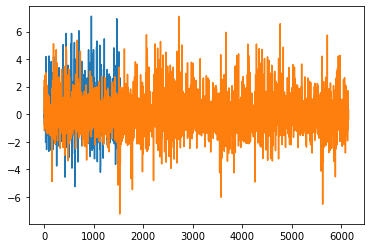

In [76]:
plt.plot(data_polo['in'][3,...].detach().numpy().flatten())
plt.plot(data_polo['out'][3,...].detach().numpy().flatten())


### Displaying Log Gabor Encoded visual field using pseudo-inverse transformation

In [77]:
inverse_transform = {}
for k in ['in', 'out']:
    N_X = N_Y = width[k] * 2**(n_levels[k]-1)
    print(N_X)
    inverse_transform[k] = transforms.Compose([
        LogGaborInvReshape(n_levels[k], n_color[k], n_eccentricity[k], n_azimuth[k], n_theta[k], n_phase[k], color=color, verbose=False),        
        LogGaborInvTransform(K_inv=K_inv[k], color=color, verbose=False),
        InvCroppedPyramid(base_levels, n_levels=n_levels[k], verbose=False, N_X=N_X, N_Y=N_Y),
    ])

128
256


- The Log-Polar compressed format

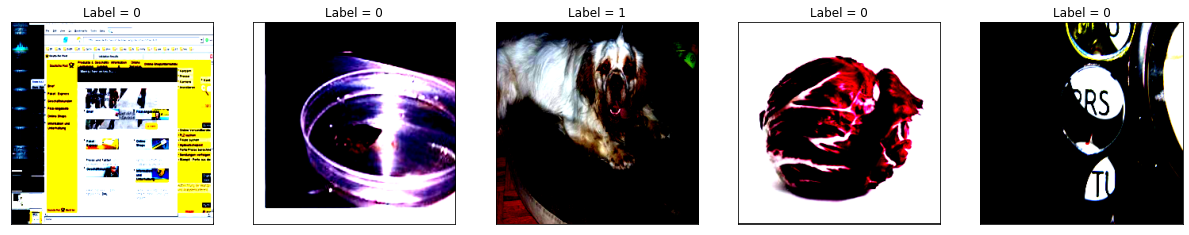

In [78]:
original = view_data(data_original, label, 5)

In [79]:
inverse_transform['in']

Compose(
)

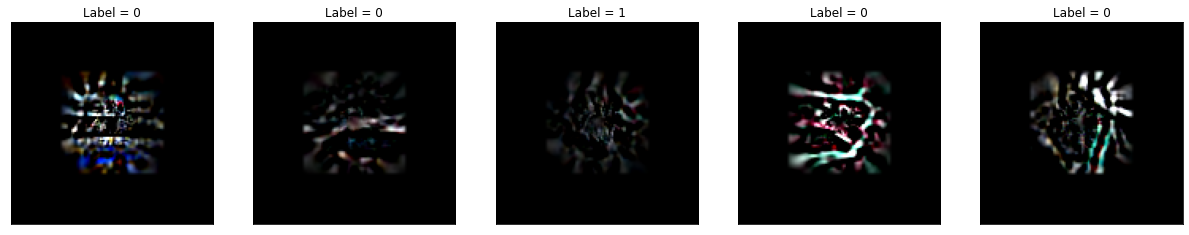

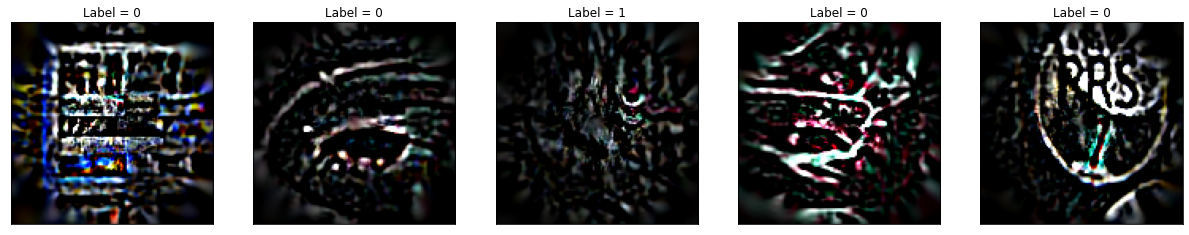

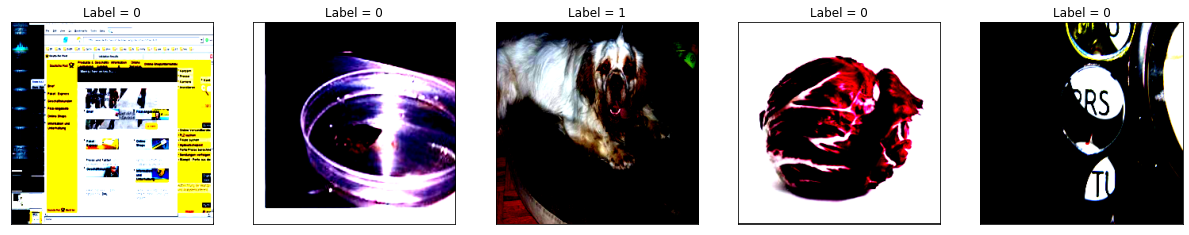

In [80]:
b = {'in':32,'out':64}
for k in ['in', 'out']:
    data = data_polo[k] #torch.cat((data_polo[k],torch.zeros_like(data_polo[k][:,:1,...])), dim=1) 
    full_img_rec = inverse_transform[k](data)
    img_aff = full_img_rec[:,:,b[k]:-b[k],b[k]:-b[k]]    
    if k == 'in':
        img_sum = full_img_rec
    else:
        img_sum += img_aff
    _ = view_data(img_sum*2, label, 5)
_ = view_data(data_original, label, 5)

- The original format

In [81]:
data_polo['in'].shape, data_polo['out'].shape

(torch.Size([50, 24, 4, 16]), torch.Size([50, 24, 8, 32]))

# Creating an Attention Transformer model with log-polar entry (POLO-STN)

In [82]:
transform_in =  transforms.Compose([
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

In [83]:
def kl_divergence(model, z, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(mu), .3 * torch.ones_like(std))

    # 2. get the probabilities from the equation
    log_qzx = model.q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    
    # sum over last dim to go from single dim distribution to multi-dim
    kl = model.LAMBDA * kl.sum()
    return kl

In [88]:
class Polo_AttentionTransNet(nn.Module):
    
    def __init__(self, do_stn=True, LAMBDA=.1, deterministic=False):
        super(Polo_AttentionTransNet, self).__init__()
        
        self.do_stn = do_stn
        self.deterministic = deterministic
        self.LAMBDA = LAMBDA

        ##  The what pathway
        self.conv1 = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
                              50, 5, padding=2)
        self.conv2a = nn.Conv2d(50, 100, 5, padding=2)
        self.conv2b = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
                               50, 5, padding=2)
        self.fc1 = nn.Linear((n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2 * (50+100), 
                              500)
        self.fc2 = nn.Linear(500, 2)
        
        ##  The where pathway        
        
        self.vgg = torchvision.models.vgg16(pretrained=True) 
        
        self.num_features = self.vgg.classifier[-1].in_features
        features = list(self.vgg.classifier.children())[:-1] # Remove last layer
        #features.extend([nn.Linear(num_features, 500)]) # Add our layer
        self.vgg.classifier = nn.Sequential(*features) # Replace the model classifier
        
        self.mu = nn.Linear(self.num_features, 2) #, bias=False)
        self.logvar = nn.Linear(self.num_features, 2) #, bias=False)

        #self.loc4.weight.data.zero_()
        #self.loc4.bias.data.zero_()

        self.downscale = nn.Parameter(torch.tensor([[1, 0], [0, 1]],
                                                   dtype=torch.float),
                                      requires_grad=False)

    def stn(self: object, x: torch.Tensor) -> Tuple[torch.Tensor]:
    
        if self.do_stn:
            
            with torch.no_grad():
                xs = self.vgg(x)
                
            mu = self.mu(xs)
            logvar = self.logvar(xs) + 3
            sigma = torch.exp(-logvar / 2)
            if self.deterministic:
                theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                    mu.size(0), 1, 1), mu.unsqueeze(2)),
                                    dim=2)
            else:
                self.q = torch.distributions.Normal(mu, sigma)
                z = self.q.rsample()
                print(z[0,...])
                theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                    z.size(0), 1, 1), z.unsqueeze(2)),
                                      dim=2)
        
            grid_size = torch.Size([x.size()[0], x.size()[1], 256, 256])
            grid = F.affine_grid(theta, grid_size)
            x = F.grid_sample(x, grid)

        else:
            theta = nn.Parameter(torch.tensor([[1, 0, 0], [0, 1, 0]],
                                                   dtype=torch.float),
                                      requires_grad=False)
            theta = theta.unsqueeze(0).repeat(x.size()[0], 1, 1)
            z = torch.tensor([0, 0],dtype=torch.float)
            z = z.unsqueeze(0).repeat(x.size()[0], 1)
            #mu = torch.tensor([0, 0],dtype=torch.float)
            #mu = mu.unsqueeze(0).repeat(x.size()[0], 1)   
            #sigma = torch.tensor([1, 1],dtype=torch.float)
            #sigma = sigma.unsqueeze(0).repeat(x.size()[0], 1)      
        return x, theta, z

    def forward(self, x, x_polo):
        # transform the input
        x, theta, z = self.stn(x)
        
        if self.do_stn:
        
            w_x_polo ={'in': torch.zeros_like(x_polo['in']),
                       'out': torch.zeros_like(x_polo['out'])}
            for i in range(batch_size):
                d, w = transform_in(x[i,...])
                w_x_polo['in'][i,...] = w['in']
                w_x_polo['out'][i,...] = w['out']
        else:
            w_x_polo = x_polo
                                           

        # print(x.shape)
        # Perform the usual forward pass
        ya = F.relu(self.conv1(w_x_polo['out']))
        ya = nn.MaxPool2d(2)(ya)        
        
        #print(xs.shape)
        
        ya = F.relu(self.conv2a(ya))
        ya = nn.MaxPool2d(2)(ya)
        
        #print(xsa.shape)
        
        yb = F.relu(self.conv2b(w_x_polo['in']))
        yb = nn.MaxPool2d(2)(yb)
        
        #print(xsb.shape)

        y = torch.cat((ya, yb), dim=1)
        y = F.relu(self.f1(y.view(-1, (50+100) * (n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2)))
        y = self.fc2(y)
        return y, theta, z

In [89]:
def train(epoch, loader):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):

        data_original, data_polo = data[0], data[1]
        data_original, data_polo['in'], data_polo['out'], target = data_original.to(
            device, dtype=torch.double), data_polo['in'].to(
                device, dtype=torch.double), data_polo['out'].to(
                device, dtype=torch.double), target.to(device)

        optimizer.zero_grad()
        output, theta, z = model(data_original, data_polo)
        if model.do_stn and not model.deterministic:
            loss = loss_func(output, target) + kl_divergence(model, z, mu, sigma)
        else:
            loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data_original),
                len(dataloader['train'].dataset),
                100. * batch_idx / len(dataloader['train']), loss.item()))


def test(loader):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data_original, data_polo = data[0], data[1]
            data_original = data_original.to(device, dtype=torch.double)            
            data_polo['in'] = data_polo['in'].to(device, dtype=torch.double) 
            data_polo['out'] = data_polo['out'].to(device, dtype=torch.double) 
            target = target.to(device)

            output, theta, z = model(data_original, data_polo)

            # sum up batch loss
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            #pred = output.max(1, keepdim=True)[1]
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(dataloader['test'].dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(dataloader['test'].dataset),
                     100. * correct / len(dataloader['test'].dataset)))
        return correct / len(dataloader['test'].dataset)

# Training 

In [90]:
lr = 1e-4
LAMBDA = 0.01
do_stn=True
deterministic=True

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = torch.load("../models/low_comp_polo_stn.pt")
model = Polo_AttentionTransNet(do_stn=do_stn, deterministic=deterministic).to(device)

In [92]:
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = optim.SGD(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9, last_epoch=-1) #, verbose=True)

In [93]:
acc = []

In [95]:
args.epochs = 100
model.do_stn = True
for epoch in range(1, args.epochs + 1):
    train(epoch, polo_dataloader['train'])
    curr_acc = test(polo_dataloader['test'])
    acc.append(curr_acc)
    #scheduler.step()

TypeError: stn() takes 2 positional arguments but 3 were given

In [ ]:
args.epochs = 100
model.do_stn = True
for epoch in range(1, args.epochs + 1):
    train(epoch, dataloader['train'])
    curr_acc = test(dataloader['test'])
    acc.append(curr_acc)
    #scheduler.step()

In [ ]:
plt.plot(acc)

In [ ]:
curr_acc = test(dataloader['test'])

In [ ]:
torch.save(model, "polo_imagenet_vgg_stn.pt")

In [ ]:
data, label = next(iter(dataloader['test']))

In [ ]:
output = model.stn(data[0], data[1])

In [ ]:
with torch.no_grad():
    cat, theta, z, _, _ = model(data[0], data[1])
cat = torch.argmax(F.softmax(cat),1)

In [ ]:
#theta = torch.cat((model.downscale.unsqueeze(0).repeat(
#            theta.size(0), 1, 1), theta.unsqueeze(2)),
#                          dim=2)
        
        #theta = theta.view(-1, 2, 3)
for num in range(50):
    plt.figure(figsize=(5,10))
    plt.subplot(1,2,1)
    img = data[0][num:num+1,...]   
    th = theta[num:num+1,...]
    #theta[0,:,2] = torch.FloatTensor((0,.5))
    #print(th)
    grid_size = torch.Size([1, 3, 256, 256])
    grid = F.affine_grid(th, grid_size)
    img_grid = F.grid_sample(img, grid)
    plt.imshow(data[0][num,...].permute(1,2,0).detach().numpy())
    plt.title(str(num)+', '+str(label[num]))
    plt.subplot(1,2,2)
    plt.imshow(img_grid[0,:].permute(1,2,0).detach().numpy())
    plt.plot(128,128,'r+')
    plt.title(cat[num])

In [ ]:
#theta = torch.cat((model.downscale.unsqueeze(0).repeat(
#            theta.size(0), 1, 1), theta.unsqueeze(2)),
#                          dim=2)
mem_z  = []
mem_cat  = []

        #theta = theta.view(-1, 2, 3)
for num in [43,]*50: #range(50):
    with torch.no_grad():
        #img = data[0][num,...].unsqueeze(0)
        #polo_img = {'in': data[1]['in'][num,...].unsqueeze(0),
        #             'out': data[1]['out'][num,...].unsqueeze(0)}
        cat, theta, z, _, _ = model(data[0], data[1])
    cat = torch.argmax(F.softmax(cat),1)
    plt.figure(figsize=(5,10))
    plt.subplot(1,2,1)
    img = data[0][num:num+1,...]   
    th = theta[num:num+1,...]
    mem_z.append(z)
    mem_cat.append(cat)
    #theta[0,:,2] = torch.FloatTensor((0,.5))
    #print(th)
    grid_size = torch.Size([1, 3, 256, 256])
    grid = F.affine_grid(th, grid_size)
    img_grid = F.grid_sample(img, grid)
    plt.imshow(data[0][num,...].permute(1,2,0).detach().numpy())
    plt.title(label[num])
    plt.subplot(1,2,2)
    plt.imshow(img_grid[0,:].permute(1,2,0).detach().numpy())
    plt.plot(128,128,'r+')
    plt.title(cat[num])


In [ ]:
for num in range(batch_size):
    plt.figure()
    plt.imshow(data[0][num,...].permute(1,2,0).detach().numpy())
    for i, z in enumerate(mem_z):
        if mem_cat[i][num] == 1:
            plt.plot(127.5 + z[num][0]*128, 127.5 + z[num][1]*128,'r+')
        else:
            plt.plot(127.5 + z[num][0]*128, 127.5 + z[num][1]*128,'b+')

In [ ]:
cat[48]

In [ ]:
mem_z[18:19]

In [ ]:
len(mem_z)

In [ ]:
plt.imshow(data[0][1,:].permute(1,2,0).detach().numpy())

In [ ]:
plt.imshow(output[0][1,:].permute(1,2,0).detach().numpy())

In [ ]:
output[1][1][:,2].detach().numpy()